In [18]:
import sys
sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn import manifold
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm

import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import numpy2ri
ro.conversion.py2ri = numpy2ri
from rpy2.robjects.packages import importr
mass = importr('MASS')

# Parameters

In [168]:
kmin= 1
kmax = 5
kincrement = 1
nclustering = 3
h_matrix = ccal.support.read_gct('../../../hematopoietic_cancer/result/ccle_hema/k9/ccle_hema_k_9_H.gct')
state = 5
exp = 1.3
ngrid = 100
CMAP_CATEGORICAL = ccal.visualize.CMAP_CATEGORICAL

# get_states

In [3]:
results = pd.DataFrame(index=range(kmin, kmax + 1, kincrement), columns=list(h_matrix.columns) + ['cophenetic_correlation'])

standardized_h_matrix = ccal.support.standardize_pandas_object(h_matrix)
standardized_and_clipped_h_matrix = standardized_h_matrix.clip(-3, 3)
compared_matrix = ccal.analyze.compare_matrices(standardized_and_clipped_h_matrix, standardized_and_clipped_h_matrix, axis=1)

for k in range(kmin, kmax + 1, kincrement):
    labels = pd.DataFrame(index=range(nclustering), columns=compared_matrix.index)
    for i in range(nclustering):
        ward = AgglomerativeClustering(n_clusters=k)
        ward.fit(compared_matrix)
        labels.iloc[i, :] = ward.labels_

    cooccurences = pd.DataFrame(index=compared_matrix.index, columns=compared_matrix.columns)
    cooccurences.fillna(0, inplace=True)
    for n, s in labels.iterrows():
        for i in s.index:
            for j in s.index:
                if i is j or s.ix[i] == s.ix[j]:
                    cooccurences.ix[i, j] += 1
    cooccurences /= nclustering

    distances = 1 - cooccurences
    link = linkage(distances, method='ward')
    labels = fcluster(link, k, criterion='maxclust')
    cophenetic_correlation = cophenet(link, pdist(distances))[0]
    results.ix[k, h_matrix.columns] = labels
    results.ix[k, 'cophenetic_correlation'] = cophenetic_correlation

<17:14:06> Comparing A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (1/166) vs. ...
<17:14:06> Comparing A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (2/166) vs. ...
<17:14:06> Comparing ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (3/166) vs. ...
<17:14:07> Comparing AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (4/166) vs. ...
<17:14:07> Comparing AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (5/166) vs. ...
<17:14:08> Comparing BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (6/166) vs. ...
<17:14:08> Comparing BDCM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (7/166) vs. ...
<17:14:09> Comparing BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (8/166) vs. ...
<17:14:09> Comparing BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (9/166) vs. ...
<17:14:10> Comparing BV173_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (10/166) vs. ...
<17:14:10> Comparing CA46_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (11/166) vs. ...
<17:14:11> Comparing CI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (12/166) vs. ...
<17:14:11> Comparing CMK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (13/166

# map_onco_gps

In [169]:
# Get components' x & y coordinates
mds = manifold.MDS()
components_coordinates = mds.fit_transform(standardized_and_clipped_h_matrix)

In [170]:
# Delaunay triangulate components' projection
delaunay = tri.Triangulation(components_coordinates[:, 0], components_coordinates[:, 1])

In [171]:
samples = pd.DataFrame(index=h_matrix.columns, columns=['label', 'x', 'y'])
# Get sample labels
samples.ix[:, 'label'] = results.ix[state, :]
# Get samples' x & y coordinates
for col_name in h_matrix:
    col = h_matrix.ix[:, col_name]
    third = col.sort_values()[-3]
    col = col.mask(col < third, other=0)
    # TODO: remove assertion
    assert sum(col != 0) == 3
    x = sum(col**exp * components_coordinates[:, 0])/sum(col**exp)
    y = sum(col**exp * components_coordinates[:, 1])/sum(col**exp)
    samples.ix[col_name, ['x', 'y']] = x, y

In [172]:
# TODO: 0 index
# Get KDE for each state
kdes = np.empty((state, ngrid, ngrid))
for s in range(state):
    print(s + 1)
    coordiantes = samples.ix[samples.ix[:, 'label'] == s + 1, ['x', 'y']]
    x = np.array(coordiantes.ix[:, 'x'], dtype=float)
    y = np.array(coordiantes.ix[:, 'y'], dtype=float)
    bandwidth_x = np.asarray(mass.bcv(x)[0])
    bandwidth_y = np.asarray(mass.bcv(y)[0])
    kde = mass.kde2d(x, y, np.asarray([bandwidth_x, bandwidth_y]), n=np.asarray([ngrid]))
    kdes[s] = np.array(kde[2])

# Get the best KDE and assign states to grids
grid_probabilities = np.empty((ngrid, ngrid))
grid_states = np.empty((ngrid, ngrid))
for i in range(ngrid):
    for j in range(ngrid):
        grid_probabilities[i, j] = max(kdes[:, i, j])
        grid_states[i, j] = np.argmax(kdes[:, i, j])

1
2
3
4
5


## plot

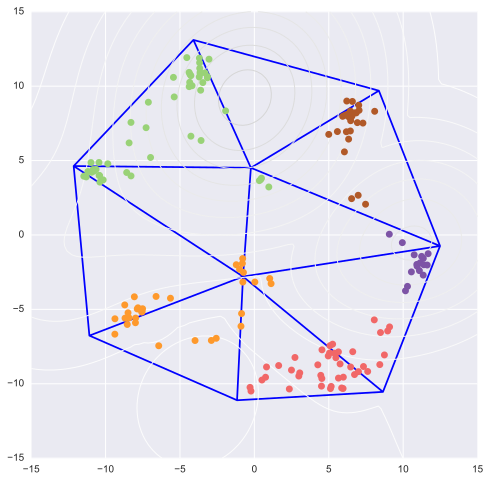

In [173]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(delaunay, color='blue')

colors = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=state), cmap=CMAP_CATEGORICAL)
for idx, s in samples.iterrows():
    # TODO: add border color
    # TODO: add size parameter
    # TODO: add size parameter
    ax.plot(s.ix['x'], s.ix['y'], marker='o', color=colors.to_rgba(s.ix['label']))

xmin, xmax, ymin, ymax = ax.axis('on')
ax.contour(np.linspace(xmin, xmax, num=ngrid), np.linspace(ymin, ymax, num=ngrid), grid_probabilities, levels=np.linspace(0, 1, 39), linewidths=1)